<a href="https://colab.research.google.com/github/ntu-dl-bootcamp/deep-learning-2024/blob/main/session3/session3_diffusion.ipynb" target="_blank"><img alt="Open In Colab" src="https://colab.research.google.com/assets/colab-badge.svg"/></a>

# Diffusion Model

[Original Notebook Source (in TensorFlow)](https://www.infocusp.com/blogs/understanding-diffusion-models-by-coding/)

[Diffusion models](https://arxiv.org/pdf/2006.11239.pdf) are a family of models that have shown amazing capability of generating photorealistic images with/ without text prompt. They have two flows as shown in the figure below -
1. Deterministic forward flow (from image to noise) and
2. Generative reverse flow (recreating image from noise).

Diffusion models get their name from the forward flow where they follow a markov chain of diffusion steps, each of which adds a small amount of random noise to the data. Then they learn the model to reverse the diffusion process and construct desired data samples from noise.

<figure>
<p style="text-align:center;"  align = "center"><img src="https://developer-blogs.nvidia.com/wp-content/uploads/2022/04/Fixed_Forward_Diffusion_Process.png" alt="Trulli" style="width:100%"  align = "center"></p>
<figcaption align = "center">Forward and reverse process <a href="https://developer.nvidia.com/blog/improving-diffusion-models-as-an-alternative-to-gans-part-1/">Ref: Nvidia blog</a> </figcaption>
</figure>



Since they map noise to data, these models can be said to be capable of learning the distributions that generate data of any particular domain.

This notebook showcases a minimal example of the forward diffusion process and its reverse mapping using a dense network. It is meant to give the reader side by side code snippets to match the equations in the paper and visual examples of the complete process.

### Imports and utility functions

In [1]:
#@title
! pip install celluloid
import math
import torch
import torch.nn as nn
import torch.distributions as dist
from torch.utils.data import TensorDataset, DataLoader
import functools
import numpy as np
from matplotlib import pyplot as plt
from celluloid import Camera
import functools
import sklearn.datasets
# For plotting
from IPython.display import HTML
from base64 import b64encode

In [2]:
#@title
# Utility function for displaying video inline in colab

def show_video(vname):
  mp4 = open(vname,'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML("""
  <video width=400 controls>
        <source src="%s" type="video/mp4">
  </video>
  """ % data_url)

def save_animation(vname, interval=30):
  anim = camera.animate(blit=True, interval=interval)
  anim.save(vname)

# Utility function for random noise
def noise_like(shape):
  return torch.randn(shape, dtype=torch.float32)

## Data Distribution

Images can be conceptualized as points sampled from a high-dimensional space with dimensions corresponding to the image's height and width.

Consider an image of dimensions $height \times width$. In such an image, the total number of pixels equals $height \times width$, each pixel having a value ranging from 0 to 255 to represent intensity.

Now, envision a vector space where we flatten this image, representing the intensity of each pixel along a single dimension of the vector. For instance, a
$2 \times 3$ image (2 pixels in height, 3 pixels in width) transforms into a single vector of length 6, with each component of this vector ranging from 0 to 255.

Within this image vector space, we observe small clusters of valid(photorealistic) images, sparsely distributed throughout the space. Conversely, the remaining vector space comprises invalid (non-photorealistic) images.

For the example in this notebook, we consider a **hypothetical** simplified version of the above representation. We consider images made of just 2 pixels, each of which can have integer values between [-5, 5]. This is to allow visualization of each dimension of the data as it moves through the forward and reverse process (and additionally faster training). Example [0, 1] is an hypothetical image for us.

The same code can be extended to the original image dimensions with just updated data dimensions.

In [3]:
# Generate original points which are around [0.5, 0.5] in all quadrants and
# 4 corners ([0,1], [1,0], [0,-1], [-1, 0])
# Some region around these points indicates valid images region (true data distribution)

# Define parameters
num_samples_per_center = 1000
stddev = 0.1
mean = 0

# Create centers tensor
centers = torch.tensor([[0, 1], [1, 0], [0, -1], [-1, 0],
                       [0.5, 0.5], [0.5, -0.5], [-0.5, -0.5],
                       [-0.5, 0.5]]) * 4
print('Hypothetical Image (2 pixels) Data:\n', centers)
# Generate data for each cluster
all_data = []
for idx in range(centers.shape[0]):
    center = centers[idx]
    normal_dist = dist.Normal(loc=center, scale=stddev)
    data = normal_dist.sample(torch.Size([num_samples_per_center]))
    all_data.append(data)

# Concatenate data into a single tensor
train_data= torch.cat(all_data, dim=0)

# Print information
print(f'{train_data.shape[0]} samples of {train_data.shape[1]} dimensions in training data')

Hypothetical Image (2 pixels) Data:
 tensor([[ 0.,  4.],
        [ 4.,  0.],
        [ 0., -4.],
        [-4.,  0.],
        [ 2.,  2.],
        [ 2., -2.],
        [-2., -2.],
        [-2.,  2.]])
8000 samples of 2 dimensions in training data


The **x's**  in the plot below can be thought of as valid images in 2d space with the rest of the white region representing the rest of the invalid images. The blue clusters around the x's are also valid images (corresponding to minor pixel perturbations in original images).

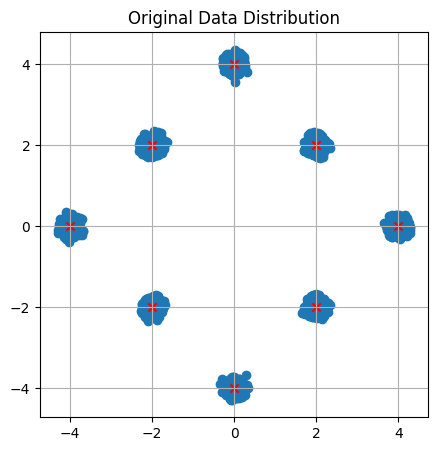

In [5]:
#@title
# Visualize the data
plt.figure(figsize=[5,5])
plt.scatter(train_data[:,0], train_data[:,1])
for center in centers.numpy():
  # print(center[0], center[1])
  plt.scatter([center[0]], [center[1]], marker='x', color='r')
plt.title('Original Data Distribution')
plt.grid()

## Beta Schedule (how much noise to add at each time step of diffusion)

With the original (non-noisy) data in hand, our next step is to initiate the diffusion model implementation. The initial phase involves introducing noise to the input images according to a predetermined variance schedule, often referred to as a beta schedule. The original paper adopts a linear schedule for this purpose. Additionally, the model typically progresses through 1000 timesteps, advancing both forward and backward. However, given the simplicity of our dataset, we opt for a smaller number of timesteps, specifically 250, to effectively capture the dynamics of the data.

**Beta derivatives**

Next, let's compute all the derivatives from beta that are used repeatedly in the forward and reverse process of diffusion. Since the variance schedule ($\beta_t$) is fixed, the derivatives of $\beta_t$ are also fixed. We precompute these to save time/ compute.

We'll see the use cases of these variables in the respective sections below.

In [10]:
num_diffusion_timesteps=250
beta_start=0.0001
beta_end=0.02
schedule_type='linear'

def get_beta_schedule(schedule_type, beta_start, beta_end, num_diffusion_timesteps):
  if schedule_type == 'quadratic':
    betas = np.linspace(beta_start ** 0.5, beta_end ** 0.5, num_diffusion_timesteps, dtype=np.float32) ** 2
  elif schedule_type == 'linear':
    betas = np.linspace(beta_start, beta_end, num_diffusion_timesteps, dtype=np.float32)
  return betas

betas_linear = get_beta_schedule('linear', beta_start, beta_end, num_diffusion_timesteps)
betas_quad = get_beta_schedule('quadratic', beta_start, beta_end, num_diffusion_timesteps)

class BetaDerivatives():
    def __init__(self, betas, dtype=torch.float32):
        """Take in betas and pre-compute the dependent values to use in forward/ backward pass.

        Values are precomputed for all timesteps so that they can be used as and
        when required.
        """
        self.np_betas = betas  # Store original numpy array for reference
        timesteps, = betas.shape
        self.num_timesteps = int(timesteps)

        self.betas = torch.tensor(betas, dtype=dtype)
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = torch.cat([torch.tensor([1.0]), self.alphas_cumprod[:-1]], dim=0)

        # Calculations required for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = torch.log(1. - self.alphas_cumprod)

    def _gather(self, a, t):
        """Utility function to extract some coefficients at specified timesteps,
        then reshape to [batch_size, 1] for broadcasting."""
        return a[t].reshape(-1, 1)

gdb = BetaDerivatives(betas_linear)

## Forward Pass of Diffusion Model

*Given an initial sample* $x_0$ *and a time* $t$, *we can directly compute the noisy sample at time* $t$.

In the forward pass, the diffused input at timestep* $t$ *can be computed directly using the closed-form equation:*

$$q(x_t| x_0) = N(\sqrt{\bar{\alpha_t}}x_o, 1-\bar{\alpha_t}I)$$

Here, $\bar{\alpha_t}$ represents the cumulative sum of the diffusion alphas up to timestep $t$. This formula is derived from the mathematical framework presented in the paper.

The `q_sample` function below implements this equation. It generates a noisy sample at timestep $t$ based on the initial sample $x_0$ and the diffusion process.


In [11]:
class DiffusionForward(BetaDerivatives):
    """
    Forward pass of the diffusion model.
    """

    def __init__(self, betas):
        super().__init__(betas)

    def q_sample(self, x_start, t, noise=None):
        """
        Forward pass - sample of diffused data at time t.
        """
        if noise is None:
            noise = torch.randn_like(x_start)  # Generate noise with same shape and device as x_start
        sqrt_alphas_cumprod = self._gather(self.sqrt_alphas_cumprod, t)
        sqrt_one_minus_alphas_cumprod = self._gather(self.sqrt_one_minus_alphas_cumprod, t)
        return sqrt_alphas_cumprod * x_start + sqrt_one_minus_alphas_cumprod * noise

# Example usage:
diff_forward = DiffusionForward(betas_linear)

### Visualize the forward diffusion of the entire data over time

We start with original data distribution and move it through the forward diffusion process 10 steps at a time. We can see that the original data distribution information is lost till it resembles gaussian after num_diffusion_steps.

Also, the slow perturbations at the start and large ones towards the end as per the beta schedule are evident from the video.

<ipython-input-12-87012d889ce1>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(train_data)  # Convert to PyTorch tensor


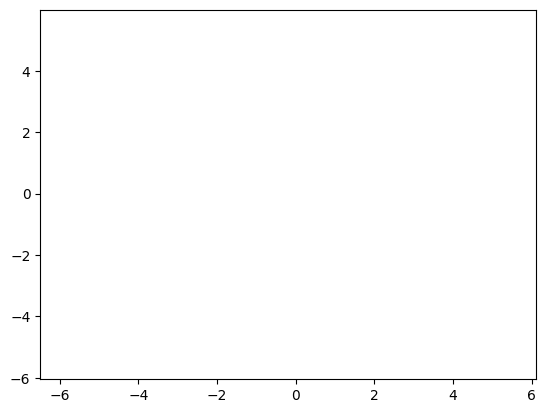

In [12]:
#@title
camera = Camera(plt.figure())

x0 = torch.tensor(train_data)  # Convert to PyTorch tensor
for timestep in range(0, num_diffusion_timesteps, 10):
    tstep = torch.full((x0.shape[0],), timestep, dtype=torch.long)  # Create timestep tensor
    shifted = diff_forward.q_sample(x0, tstep)
    plt.scatter(shifted[:, 0].numpy(), shifted[:, 1].numpy(), c=np.arange(x0.shape[0]) // num_samples_per_center)
    camera.snap()

animation = camera.animate(interval=300)  # Adjust interval as needed
animation.save('scatter.mp4')

In [13]:
show_video('scatter.mp4')

### Visualize the forward pass of single point

We perform the forward diffusion of a single point over time. At every timestep, we generate 500 possible diffused samples of the same input point. We observe the distribution of these points over time.

These too are closer to the original point at the start and move towards gaussian as the forward process reaches num_timesteps same as the example above.

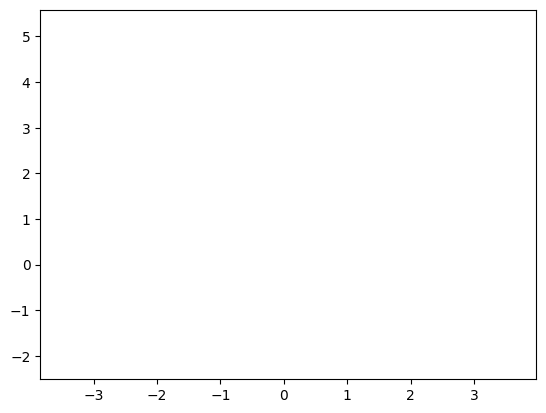

In [14]:
#@title
camera = Camera(plt.figure())

# Define initial positions
x0 = torch.tensor([[0.0, 4.0]]).repeat(500, 1)

for timestep in range(0, num_diffusion_timesteps, 10):
    # Create timestep tensor with repeated values and correct data type
    tstep = torch.full((500,), timestep, dtype=torch.long)

    # Perform diffusion sampling using the PyTorch model
    shifted = diff_forward.q_sample(x0, tstep)

    # Plot both shifted and original points with clear labels and legend
    plt.scatter(shifted[:, 0], shifted[:, 1], c='b', label=f'Time step: {timestep}')
    plt.scatter(x0[:, 0], x0[:, 1], marker='x', c='r', label='Initial')

    # Capture frame for the animation
    camera.snap()

# Save the animation
animation = camera.animate(interval=300)  # Adjust interval as needed
animation.save('pointshifting.mp4')


In [15]:
show_video('pointshifting.mp4')

## NN Model

With the data preprocessed, we proceed to construct a suitable model for fitting the data. Given the simplicity of our dataset, consisting of only 2 features to reconstruct, we opt for a shallow Deep Neural Network (DNN) with a few layers. However, in the case of image data, we would substitute this architecture with a UNet, which is better suited for handling spatial data, while retaining a similar loss function for optimization.

The model takes in 2 inputs:
* Timestep embedding of $t$
* $x_t$

And predicts
* The noise $n$ that lead from $x_0$ to $x_t$

### Timestep Embedding

In [16]:
# We create a 128 dimensional embedding for the timestep input to the model.
# Fixed embeddings similar to positional embeddings in transformer are used -
# could be replaced by trainable embeddings later

def get_timestep_embedding(timesteps, embedding_dim: int):
    half_dim = embedding_dim // 2
    emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -emb)
    emb = timesteps.float().unsqueeze(1) * emb.unsqueeze(0)
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    if embedding_dim % 2 == 1:  # zero pad
        emb = torch.nn.functional.pad(emb, (0, 1), "constant", 0)
    return emb

temb = get_timestep_embedding(torch.tensor([2, 3]), 128)
print(temb.shape)
print('Embedding for time step 2:\n', temb[0])

torch.Size([2, 128])
Embedding for time step 2:
 tensor([ 9.0930e-01,  9.8767e-01,  9.9697e-01,  9.6081e-01,  8.9767e-01,
         8.2084e-01,  7.3922e-01,  6.5845e-01,  5.8185e-01,  5.1116e-01,
         4.4714e-01,  3.8989e-01,  3.3917e-01,  2.9454e-01,  2.5545e-01,
         2.2133e-01,  1.9163e-01,  1.6583e-01,  1.4344e-01,  1.2404e-01,
         1.0724e-01,  9.2699e-02,  8.0120e-02,  6.9241e-02,  5.9836e-02,
         5.1705e-02,  4.4678e-02,  3.8604e-02,  3.3356e-02,  2.8820e-02,
         2.4901e-02,  2.1515e-02,  1.8589e-02,  1.6061e-02,  1.3877e-02,
         1.1989e-02,  1.0359e-02,  8.9499e-03,  7.7326e-03,  6.6809e-03,
         5.7722e-03,  4.9872e-03,  4.3089e-03,  3.7228e-03,  3.2165e-03,
         2.7790e-03,  2.4010e-03,  2.0744e-03,  1.7923e-03,  1.5485e-03,
         1.3379e-03,  1.1559e-03,  9.9872e-04,  8.6288e-04,  7.4552e-04,
         6.4412e-04,  5.5651e-04,  4.8082e-04,  4.1542e-04,  3.5892e-04,
         3.1010e-04,  2.6793e-04,  2.3148e-04,  2.0000e-04, -4.1615e-01,
  

In [17]:
# Actual model that takes in x_t and t and outputs n_{t-1}
# Experiments showed that prediction of n_{t-1} worked better compared to
# prediction of x_{t-1}

class NoiseModel(nn.Module):
    def __init__(self, input_feat, temb_feat):
        super(NoiseModel, self).__init__()
        self.d1 = nn.Linear(input_feat, temb_feat)
        self.d2 = nn.Sequential(
            nn.Linear(temb_feat*2, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
        )

    def forward(self, input_x, temb):
        out_d1 = self.d1(input_x)
        merged = torch.cat((temb, out_d1), dim=1)
        out_d2 = self.d2(merged)
        return out_d2

# Define input and time embedding dimensions
input_feat = train_data.shape[1]
temb_feat = 128

# Instantiate the model
model = NoiseModel(input_feat, temb_feat)

print(model) # Equivalent to model.summary() in Keras
criterion = nn.MSELoss()  # Equivalent to loss='mse'
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)  # Equivalent to optimizer='adam'

NoiseModel(
  (d1): Linear(in_features=2, out_features=128, bias=True)
  (d2): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=2, bias=True)
  )
)


### Data Generation for Diffusion Model

Next, let's generate the data for the model to train. We generate $x_t$ given the input $x_0$ using the deterministic forward process equation described above. This $x_t$ and timestep embedding of
$t$ are input to the model that is tasked with predicting the noise $n$.

$t$ is picked uniformly between [0, num_diffusion_timesteps]

In [19]:
shuffle_buffer_size = 1000
batch_size = 32

def data_generator_forward(x, gdb):
    x=torch.stack(x)
    tstep = torch.randint(0, num_diffusion_timesteps, (x.shape[0],), dtype=torch.int32)
    noise = torch.randn_like(x)
    noisy_out = gdb.q_sample(x, tstep, noise)
    timestep_emb = get_timestep_embedding(tstep, 128)
    return (noisy_out, timestep_emb), noise


dataloader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=lambda batch: data_generator_forward(batch, gdb=diff_forward)  # Pass gdb as an argument
)

In [20]:
# Let's test the data generator
(xx,tt),yy = next(iter(dataloader))
print(xx.shape, tt.shape, yy.shape)

torch.Size([32, 2]) torch.Size([32, 128]) torch.Size([32, 2])


### Train and Evaluate the model

In [21]:
# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    for (input_x, temb), noise in dataloader:
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        predicted_noise = model(input_x, temb)

        # Compute the loss
        loss = criterion(predicted_noise, noise)

        # Backward pass
        loss.backward()

        # Update the parameters
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/200], Loss: 1.0592
Epoch [2/200], Loss: 1.2091
Epoch [3/200], Loss: 0.6836
Epoch [4/200], Loss: 0.8262
Epoch [5/200], Loss: 0.6251
Epoch [6/200], Loss: 0.6290
Epoch [7/200], Loss: 0.6150
Epoch [8/200], Loss: 0.8156
Epoch [9/200], Loss: 0.7236
Epoch [10/200], Loss: 0.4079
Epoch [11/200], Loss: 0.6782
Epoch [12/200], Loss: 0.3923
Epoch [13/200], Loss: 0.3623
Epoch [14/200], Loss: 0.8572
Epoch [15/200], Loss: 0.7340
Epoch [16/200], Loss: 0.6620
Epoch [17/200], Loss: 0.6414
Epoch [18/200], Loss: 0.6680
Epoch [19/200], Loss: 0.4800
Epoch [20/200], Loss: 0.5535
Epoch [21/200], Loss: 0.4985
Epoch [22/200], Loss: 0.4267
Epoch [23/200], Loss: 0.5028
Epoch [24/200], Loss: 0.6571
Epoch [25/200], Loss: 0.6064
Epoch [26/200], Loss: 0.4665
Epoch [27/200], Loss: 0.5612
Epoch [28/200], Loss: 0.6520
Epoch [29/200], Loss: 0.4992
Epoch [30/200], Loss: 0.4652
Epoch [31/200], Loss: 0.5813
Epoch [32/200], Loss: 0.5977
Epoch [33/200], Loss: 0.3810
Epoch [34/200], Loss: 0.7254
Epoch [35/200], Loss: 0

### Scatter plots of reconstructed values v/s target

When the predictions perfectly match the target values, the scatter plot would form a diagonal line along the line y=x, which represents a perfect alignment between predicted and actual values. In the plot below, we can observe a similar trend, where the points cluster around the line y=x, albeit with some deviation. This behavior indicates that the model's predictions closely align with the target values, suggesting that the model performs reasonably well in predicting the target.

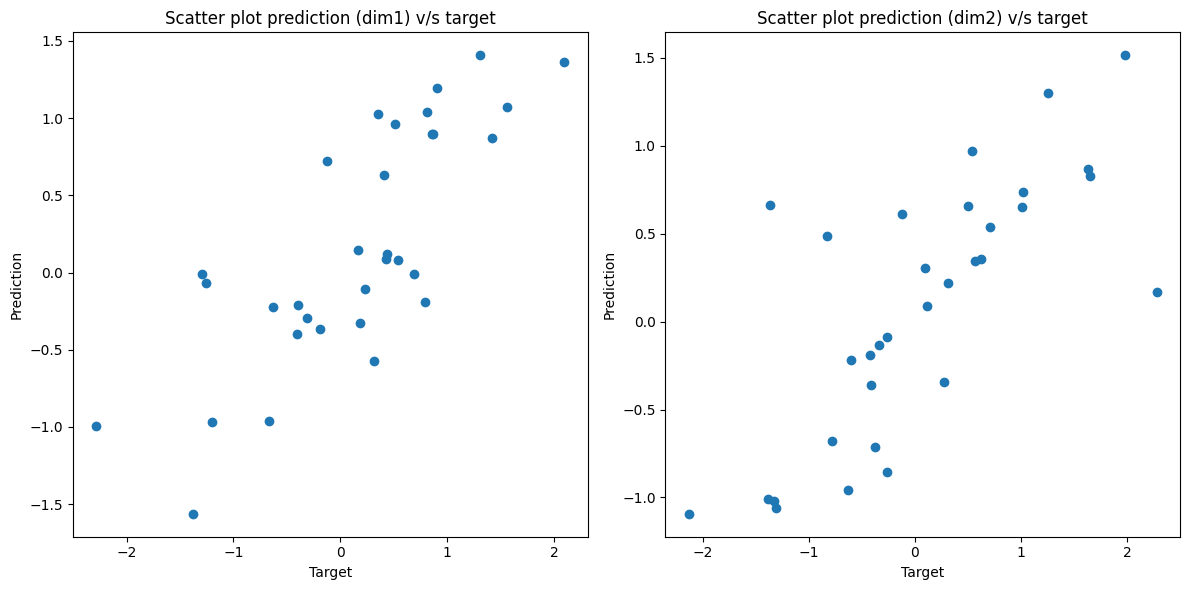

In [22]:
#@title

# Disable gradient calculation for evaluation
with torch.no_grad():
    # Get a batch of data from the dataloader
    ((xx, tt), yy) = next(iter(dataloader))

    # Forward pass through the model to get predictions
    ypred = model(xx, tt)

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=[12,6])

# Plot for dimension 1
plt.subplot(1,2,1)
plt.scatter(yy[:,0], ypred[:,0].detach())  # Use detach to prevent gradients from being tracked
plt.title('Scatter plot prediction (dim1) v/s target')
plt.xlabel('Target')
plt.ylabel('Prediction')

# Plot for dimension 2
plt.subplot(1,2,2)
plt.scatter(yy[:,1], ypred[:,1].detach())  # Use detach to prevent gradients from being tracked
plt.title('Scatter plot prediction (dim2) v/s target')
plt.xlabel('Target')
plt.ylabel('Prediction')

plt.tight_layout()
plt.show()


## Reverse Diffusion Process (Constructing Image from Noise)

The model provides a decent estimate of the noise given the data and t.  Now comes the tricky part: given the data at timestep t $x_t$, and the noise estimate from the model, reconstructing original data distribution.


There are 4 parts in the reverse process:
1. Pass $x_t$ and $t$ (converted to time embedding) into the model that predicts the noise $ϵ$
2. Using the noise estimate $ϵ$ and $x_t$, compute $x_0$ using equation : $\frac{1}{\sqrt{\bar{\alpha}_t}}x_t - (\sqrt{\frac{1}{\bar{\alpha}_t}-1}) \epsilon$


3. Compute mean and variance using the equations:

$\tilde{\mu}(x_t, x_0) = \frac{\sqrt{\bar{\alpha}_{t-1}} \beta_t}{1-\bar{\alpha_t}}x_0 + \frac{\sqrt{\bar{\alpha}_t}(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t}x_t$ and
variance $\tilde{\beta}_t = \frac{(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t}\beta_t$

4. Sample using this mean and variance
$q(x_{t−1}|x_t, x_0)=N(x_{t−1}; \tilde{\mu}(x_t, x_0), \tilde{\beta}_tI)$

In [23]:
class DiffusionReconstruct(BetaDerivatives):

  def __init__(self, betas):
    super().__init__(betas)

    self.betas = torch.tensor(betas)
    self.sqrt_recip_alphas_cumprod = torch.sqrt(1. / self.alphas_cumprod)
    self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1. / self.alphas_cumprod - 1)

    # Calculations required for posterior q(x_{t-1} | x_t, x_0)
    # Variance choice corresponds to 2nd choice mentioned in the paper
    self.posterior_variance = self.betas * (1. - self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)

    # Clip the log calculation because the posterior variance is 0 at the beginning of the diffusion chain
    self.posterior_log_variance_clipped = torch.log(torch.clamp(self.posterior_variance, min=1e-20))
    self.posterior_mean_coef1 = self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)
    self.posterior_mean_coef2 = (1. - self.alphas_cumprod_prev) * torch.sqrt(self.alphas) / (1. - self.alphas_cumprod)

  def predict_start_from_noise(self, x_t, t, noise):
        """
        Reconstruct x_0 using x_t, t and noise. Uses a deterministic process.
        """
        return (
            self._gather(self.sqrt_recip_alphas_cumprod, t) * x_t -
            self._gather(self.sqrt_recipm1_alphas_cumprod, t) * noise
        )

  def q_posterior(self, x_start, x_t, t):
        """
        Compute the mean and variance of the diffusion posterior q(x_{t-1} | x_t, x_0)
        """
        posterior_mean = (
            self._gather(self.posterior_mean_coef1, t) * x_start +
            self._gather(self.posterior_mean_coef2, t) * x_t
        )
        posterior_log_variance_clipped = self._gather(self.posterior_log_variance_clipped, t)
        return posterior_mean, posterior_log_variance_clipped

  def p_sample(self, model, x_t, t):
        """
        Sample from the model. This does 4 things:
        * Predict the noise from the model using x_t and t
        * Create an estimate of x_0 using x_t and noise (reconstruction)
        * Estimate the model mean and log_variance of x_{t-1} using x_0, x_t, and t
        * Sample data (for x_{t-1}) using the mean and variance values
        """
        with torch.no_grad():
          noise_pred = model(x_t, get_timestep_embedding(t, 128))  # Step 1
        x_recon = self.predict_start_from_noise(x_t, t=t, noise=noise_pred)  # Step 2
        model_mean, model_log_variance = self.q_posterior(x_start=x_recon, x_t=x_t, t=t)  # Step 3
        noise = noise_like(x_t.shape)  # Assuming noise_like is defined elsewhere
        nonzero_mask = torch.reshape(torch.gt(t, 0).float(), (x_t.shape[0], 1))
        return model_mean + torch.exp(0.5 * model_log_variance) * noise * nonzero_mask  # Step 4

  def p_sample_loop_trajectory(self, model, shape):
        """
        Generate the visualization of intermediate steps of the reverse of diffusion process.
        """
        times = torch.tensor([self.num_timesteps - 1], dtype=torch.int32)
        imgs = torch.stack([noise_like(shape)])

        while times[-1] >= 0:
            times = torch.cat([times, torch.tensor([times[-1] - 1])], dim=0)
            img = self.p_sample(model=model, x_t=imgs[-1], t=torch.full((shape[0],), times[-1], dtype=torch.int32))
            imgs = torch.cat([imgs, img.unsqueeze(0)], dim=0)
        return times, imgs

In [24]:
rec_diff = DiffusionReconstruct(betas_linear)
pred_ts, pred_data = rec_diff.p_sample_loop_trajectory(model, shape=(1000,2))

### Visualize the Reverse Diffusion Process

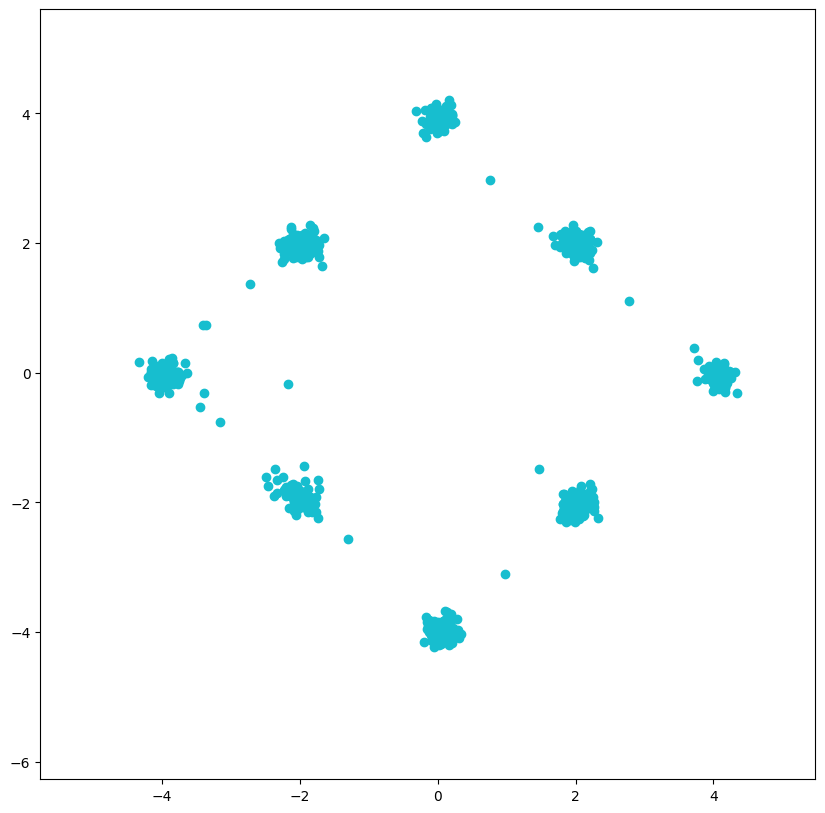

In [27]:
#@title
camera = Camera(plt.figure(figsize=(10,10)))

for timestep in range(0, num_diffusion_timesteps):
  plt.scatter(pred_data[timestep][:,0], pred_data[timestep][:,1])
  camera.snap()

save_animation('outcomes.mp4')

In the below video, we show the reconstruction process of the data from noise. We start with 100 samples  from std. normal distribution (gaussian noise) and iteratively move towards the original data distribution using the model trained above.

As you can see towards the end of the video below, the noise maps back to the original data distribution.

In [26]:
show_video('outcomes.mp4')

References:
1. [Diffusion models repo](https://github.com/hojonathanho/diffusion)
2. [Diffusion models paper](https://arxiv.org/pdf/2006.11239.pdf)
3. [Improved Denoising Diffusion Probabilistic Models paper](https://arxiv.org/pdf/2102.09672.pdf)